In [120]:
import math
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import sklearn.cluster
import sklearn.preprocessing
import sklearn.decomposition
import scipy.stats as sc
plt.style.use("ggplot")

def fix_unit(df,cols):
    for i in cols:

        ## fix unit M
        rs = df[df[i].str.match(pat = r'\d*.*\d*M')][i]
        if rs.shape[0]<1:
            pass
        else:
            to_rep = rs.values
            value = []
            for j in rs:
                idx = j.find('M')
                value.append(j[:idx])
            df[i].replace(to_replace = to_rep,value = value, inplace = True)

        ## fix unit K
        rs = df[df[i].str.match(pat = r'\d*.*\d*K')][i]
        if rs.shape[0]<1:
            pass
        else:
            to_rep = rs.values
            value = []
            for j in rs:
                idx = j.find('K')
                value.append(float(j[:idx])/1000)
            df[i].replace(to_replace = to_rep,value = value, inplace = True)

def df_astype(df,cols,type):
    for i in cols:
        df[i] = df[i].astype(type)
    return

def fix_Year(df):
    idx = df.query('Year < 1950').index.values
    to_rep = []
    var = []
    for i in range(idx.shape[0]):
        tmp = df.iloc[idx[i]]['Year']
        to_rep.append(tmp)
        if(tmp>50):
            var.append(tmp+1900)
        else:
            var.append(tmp+2000)
    df['Year'].replace(to_replace= to_rep,value = var, inplace = True)
    return

def drop_dup(df,subset_3):
    dname_idx = df[subset_3].value_counts()
    dname = dname_idx[df[subset_3].value_counts()>1]
    for i in range(dname.shape[0]):
        #print('(%s == "%s") and(%s == %d) and(%s == "%s")' %(subset_3[0],dname.index[i][0],subset_3[1],dname.index[i][1],subset_3[2],dname.index[i][2]))
        drop_dup_idx = df.query('(%s == "%s") and(%s == %d) and(%s == "%s")' %(subset_3[0],dname.index[i][0],subset_3[1],dname.index[i][1],subset_3[2],dname.index[i][2])).index.values
        df.drop(labels = drop_dup_idx, inplace= True)
    return

def scree_plot(array,len_arr):
  cmap = plt.cm.get_cmap('hsv',len_arr*3 )
  c = []
  arr_cum = []

  for i in range(len_arr):
    c.append(cmap(i))
  for i in range(len_arr):
    arr_cum.append(sum(array[:i+1]))
  plt.style.use("ggplot")
  plt.plot(arr_cum, label = 'Cumulative explanatory rate',marker = '.')
  plt.xlabel = ('PCA index')
  plt.ylabel = ('PCA explained variance ratio')
  plt.title("Scree plot")
  plt.legend(loc = 'best')
  plt.bar(x = range(len_arr), height = array,color = c)
  plt.show()

df = pd.read_csv('vgames2_g.csv')

year_null_idx = df[df.Year.isnull()].index.values
sales_cols = ['NA_Sales','EU_Sales','JP_Sales','Other_Sales']
drop_subset = ['Name','Year','Platform']

fix_unit(df,sales_cols)
df_astype(df,sales_cols,float)
fix_Year(df)
drop_dup(df,drop_subset)
df.to_csv('vgames2_h.csv')

df = pd.read_csv('vgames2_h.csv')
df['Whole_Sales'] = df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales']

df = df.dropna()
df = df.drop(df.query('(Year>2015)or(Year<1990)').index.values)


C:\Users\user\AppData\Local\Temp\ipykernel_3412\698432147.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  reg_ge_df = df.groupby('Genre').sum()


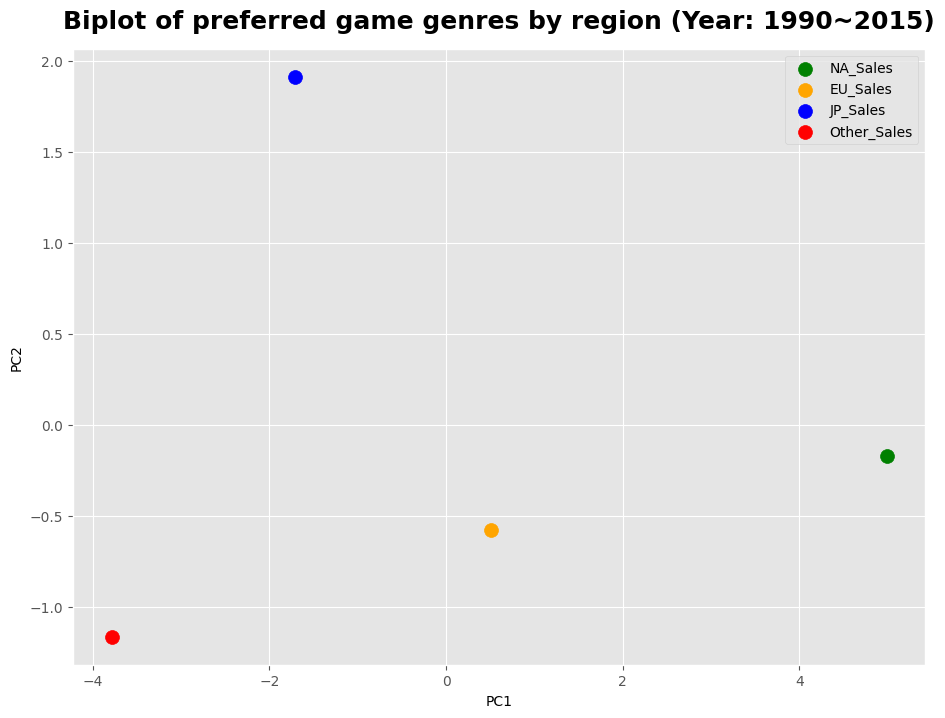

In [135]:
#### 지역에 따라서 선호하는 게임 장르 분석
## 지역별로 선호하는 게임의 장르가 같은가? 트렌드 분석
reg_ge_df = df.groupby('Genre').sum()
reg_ge_df.drop(['Unnamed: 0','Year','Whole_Sales'],axis = 1,inplace = True)
ge_reg_df = reg_ge_df.T
scaler2 = sklearn.preprocessing.StandardScaler()
ge_reg_df_scaled = scaler2.fit_transform(ge_reg_df)
pca2 = sklearn.decomposition.PCA()
score2 = pca2.fit_transform(ge_reg_df_scaled)
explained_varr2 = pca2.explained_variance_ratio_
# scree_plot(explained_varr2,len(explained_varr2))
pca2 = sklearn.decomposition.PCA(n_components=2)
score2 = pca2.fit_transform(ge_reg_df_scaled)

plt.figure(figsize = (11,8))
plt.xlabel('PC1')
plt.ylabel('PC2')
scc=['green','orange','blue','red']
scl = ge_reg_df.index.values
for i in range(score2.shape[0]):
    plt.scatter(x = score2.T[0][i],y = score2.T[1][i],label = scl[i], s=100,color=scc[i])
plt.title('Biplot of preferred game genres by region (Year: 1990~2015)',fontsize = 18,fontweight = 'bold',y=1.02)
plt.legend()
# 유럽과 북아메리카가 서로 유사한 트렌드를 보이고 일본과 타 지역은 서로 다른 트렌드를 보임.

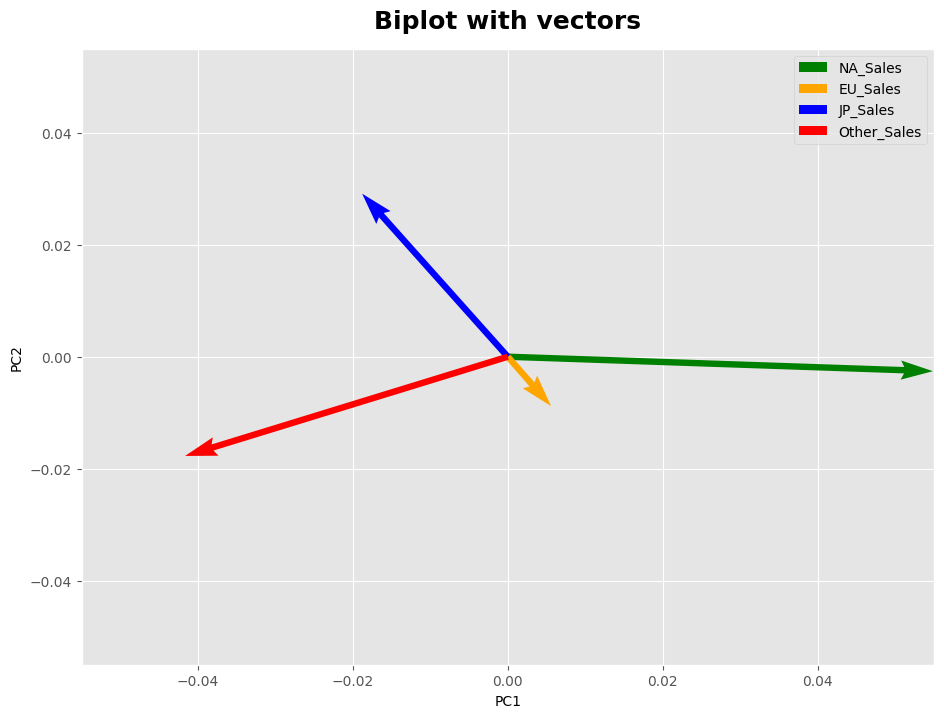

In [152]:
origin = np.array([[0],[0]])
plt.figure(figsize = (11,8))
for i in range(score2.shape[0]):
    plt.quiver(*origin,score2.T[0][i],score2.T[1][i],color=scc[i],scale = 10,label = scl[i])
plt.title('Biplot with vectors',fontsize = 18,fontweight = 'bold',y=1.02)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
NA_Sales,874.62,107.59,223.74,411.92,446.64,123.80,359.34,327.26,582.59,183.14,681.01,68.75
EU_Sales,522.82,65.13,101.37,217.09,201.63,50.75,238.38,188.05,313.27,113.39,376.32,45.35
JP_Sales,158.47,53.34,87.51,108.35,130.65,56.92,56.69,352.31,38.28,63.86,134.83,49.46
Other_Sales,186.76,17.22,36.69,75.58,51.54,12.55,77.27,59.61,102.69,31.51,134.70,11.36


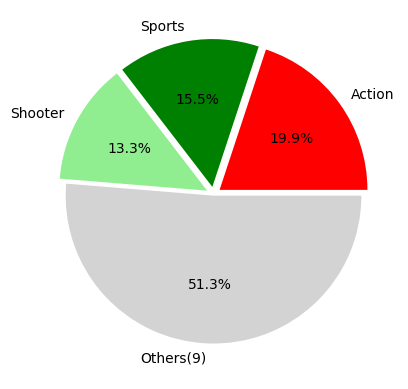

In [6]:
pref_df = reg_ge_df/reg_ge_df.sum()
na =pref_df['NA_Sales'].sort_values(ascending=False)[:3]
na = pd.concat([na,pd.Series(1-na.sum())])
eu =pref_df['EU_Sales'].sort_values(ascending=False)[:3]
eu = pd.concat([eu,pd.Series(1-eu.sum())])
jp =pref_df['JP_Sales'].sort_values(ascending=False)[:3]
jp = pd.concat([jp,pd.Series(1-jp.sum())])
ot =pref_df['Other_Sales'].sort_values(ascending=False)[:3]
ot = pd.concat([ot,pd.Series(1-ot.sum())])

na_lable = np.append(pref_df['NA_Sales'].sort_values(ascending=False)[:3].index.values,'Others(9)')
eu_lable = np.append(pref_df['EU_Sales'].sort_values(ascending=False)[:3].index.values,'Others(9)')
jp_lable = np.append(pref_df['JP_Sales'].sort_values(ascending=False)[:3].index.values,'Others(9)')
ot_lable = np.append(pref_df['Other_Sales'].sort_values(ascending=False)[:3].index.values,'Others(9)')

explode = [0.05, 0.05, 0.05, 0.01]
color1 = ['red','green','lightgreen','lightgray']
plt.pie(na,labels = na_lable, autopct='%.1f%%',explode=explode,colors=color1)

ge_reg_df

([<matplotlib.patches.Wedge at 0x1c7c379f070>,
 [Text(0.8978598893300348, 0.7185733220293237, 'Action'),
  Text(-0.30106654856177717, 1.10989140610111, 'Sports'),
  Text(-1.0520654030899734, 0.4643903397155588, 'Shooter'),
  Text(-0.006254839099090619, -1.1099823768816535, 'Others(9)')],
 [Text(0.5074860244039326, 0.4061501385383133, '21.5%'),
  Text(-0.17016804918709139, 0.6273299251875839, '15.5%'),
  Text(-0.5946456626160718, 0.262481496360968, '12.9%'),
  Text(-0.00343734400941016, -0.6099903152232509, '50.2%')])

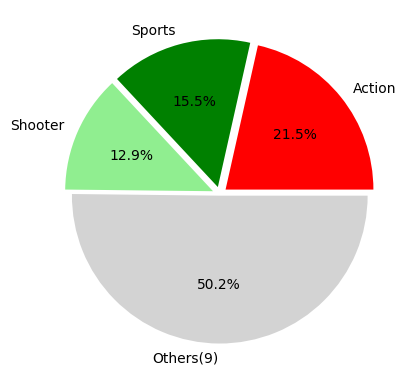

In [7]:
plt.pie(eu,labels = eu_lable, autopct='%.1f%%',explode=explode,colors=color1)

([<matplotlib.patches.Wedge at 0x1c7c3772080>,
 [Text(0.7524357836519251, 0.8696783264403648, 'Role-Playing'),
  Text(-0.5813958857090313, 0.9922090626882074, 'Action'),
  Text(-1.0891178145917657, 0.36921861537422046, 'Sports'),
  Text(0.0007429647763338122, -1.1099997513528286, 'Others(9)')],
 [Text(0.4252897907597837, 0.4915573149445539, '27.3%'),
  Text(-0.32861506583553945, 0.5608138180411607, '12.3%'),
  Text(-0.61558832998665, 0.20868878260282026, '10.4%'),
  Text(0.00040829595816542827, -0.6099998633560589, '50.0%')])

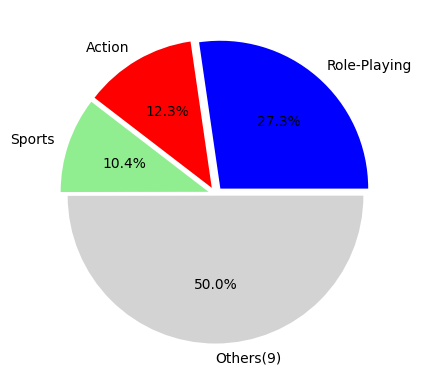

In [8]:
color2 = ['blue','red','lightgreen','lightgray']
plt.pie(jp,labels = jp_lable,autopct='%.1f%%',explode=explode,colors=color2)

([<matplotlib.patches.Wedge at 0x1c7c37ef910>,
 [Text(0.8525480977993688, 0.7717912547694992, 'Action'),
  Text(-0.48074479808058, 1.0446934665816872, 'Sports'),
  Text(-1.1260751756586451, 0.2333553058435822, 'Shooter'),
  Text(0.11092576344786204, -1.1044435137224127, 'Others(9)')],
 [Text(0.48187501179964315, 0.4362298396523256, '23.4%'),
  Text(-0.2717253206542409, 0.590478915893997, '16.9%'),
  Text(-0.6364772731983646, 0.13189647721593775, '12.9%'),
  Text(0.06095920333621247, -0.6069464354690736, '46.8%')])

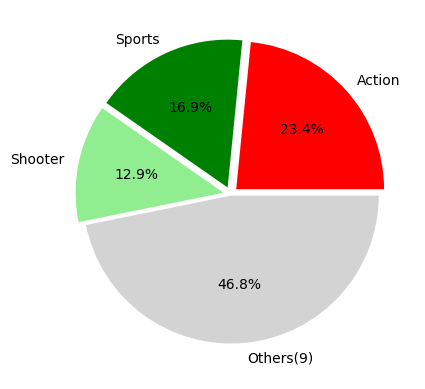

In [9]:
plt.pie(ot,labels = ot_lable,autopct='%.1f%%',explode=explode,colors=color1)

0.053
2.3951412452656


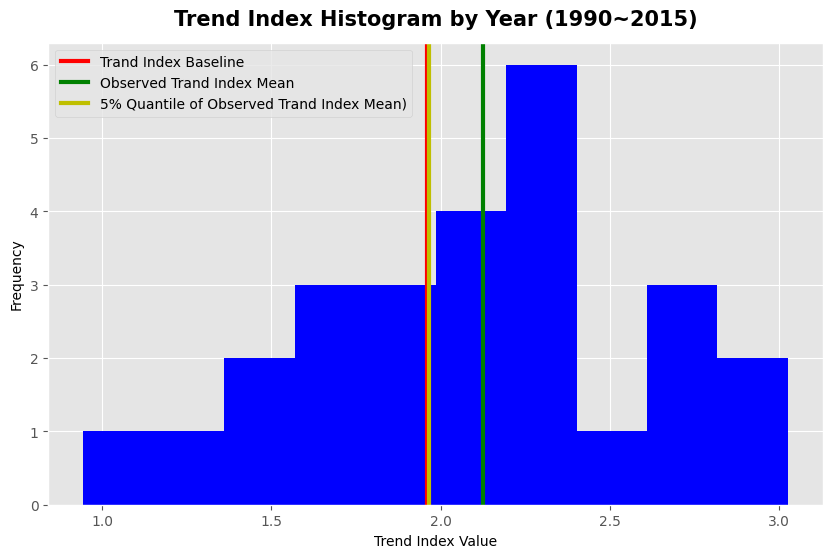

In [180]:
#### 연도별 게임의 트렌드가 있는가
## 가장 높은 출시 점유율을 가진 게임 장르의 트렌드 지수가 1.96보다 클 경우 트렌드가 있다고 가정.
## 트렌드 지수 = Xmax-m/sigma
## 귀무가설: 연도별 트렌드 지수가 1.96 보다 작거나 같다.
## 대립가설: 연도별 트렌드 지수가 1.96 보다 크다.
def trand_index(x,m,sigma):
    return (x-m)/sigma
data = df.groupby('Year')['Genre'].value_counts(normalize = True)
t_obs = []
ilst = df['Year'].value_counts().index.values
for i in ilst:
    x = data[i][0]
    m = data[i].mean()
    s = data[i].std()
    t_obs.append(trand_index(x,m,s))
nn = 1.96
t = sc.ttest_1samp(a=t_obs,popmean=nn,alternative = 'greater')
plt.figure(figsize = (10,6))
plt.hist(t_obs,color = 'b',bins = 10)
plt.xlabel('Trend Index Value')
plt.ylabel('Frequency')
plt.axvline(nn,label='Trand Index Baseline',color = 'r',linewidth = 3)
plt.axvline((sum(t_obs)/len(t_obs)),label='Observed Trand Index Mean',color = 'g',linewidth = 3)
plt.axvline((sum(t_obs)/len(t_obs)-1.645*np.std(t_obs)/math.sqrt(len(t_obs))), label='5% Quantile of Observed Trand Index Mean)',color = 'y',linewidth = 3)
plt.legend(fontsize = 10)
plt.title('Trend Index Histogram by Year (1990~2015)',fontsize = 15, fontweight = 'bold',y=1.02)
print(round(t.pvalue,3))
# pvalue가 정확히 유의수준 0.053 이므로 귀무가설을 기각할 수 없다. 즉 연도별 트렌드 지수 평균이 1.96보다 작거나 같다.
# 따라서 연도별 게임의 트렌드가 존재하지 않는다.
# 전체 게임 트렌드 지수:
ndata = df['Genre'].value_counts(normalize = True)
nTI = (ndata[0]-ndata.mean())/ndata.std()
print(nTI)


0.0


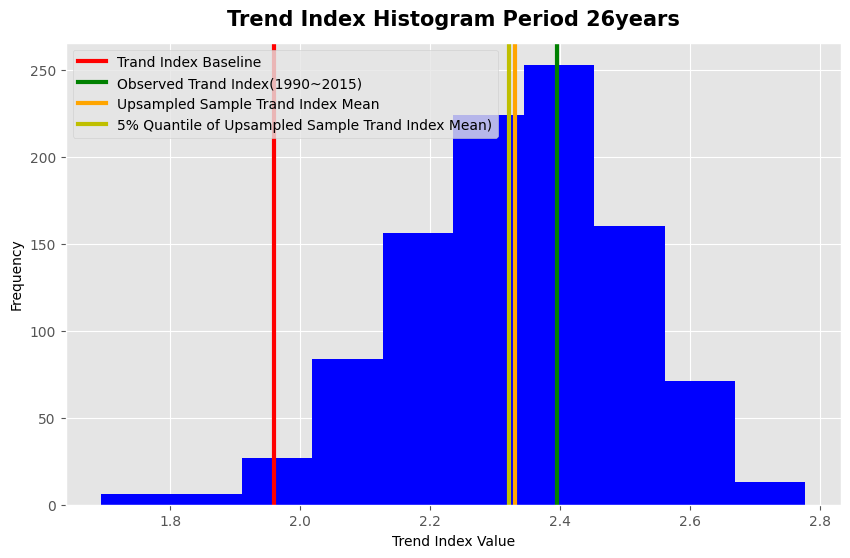

In [214]:
## 26년간 트렌드 지수 데이터 업샘플링
data = df.groupby('Year')['Genre'].value_counts()
t_ups = []
ilst = df['Year'].value_counts().index.values
period = 26
sample_size = 1000
np.random.seed(42)
for i in range(sample_size):
    new_ilst = np.random.choice(ilst,period)
    tmp = pd.Series(index = df['Genre'].value_counts().index,data = [0]*12)
    for j in new_ilst:
        tmp = tmp + data.fillna(value=0)[j]
        tmp = tmp.fillna(value=0)
    x = (tmp/tmp.sum())[0]
    m = (tmp/tmp.sum()).mean()
    s = (tmp/tmp.sum()).std()
    t_ups.append(trand_index(x,m,s))
nn = 1.96
t = sc.ttest_1samp(a=t_ups,popmean=nn,alternative = 'greater')
plt.figure(figsize = (10,6))
plt.hist(t_ups,color = 'b',bins = 10)
plt.xlabel('Trend Index Value')
plt.ylabel('Frequency')
plt.axvline(nn,label='Trand Index Baseline',color = 'r',linewidth = 3)
plt.axvline((nTI),label='Observed Trand Index(1990~2015)',color = 'g',linewidth = 3)
plt.axvline(sum(t_ups)/len(t_ups),label='Upsampled Sample Trand Index Mean',color = 'orange',linewidth = 3)
plt.axvline((sum(t_ups)/len(t_ups)-1.645*np.std(t_ups)/math.sqrt(len(t_ups))), label='5% Quantile of Upsampled Sample Trand Index Mean)',color = 'y',linewidth = 3)
plt.legend(fontsize = 10)
plt.title('Trend Index Histogram Period 26years',fontsize = 15, fontweight = 'bold',y=1.02)
print(round(t.pvalue,3))

([<matplotlib.patches.Wedge at 0x1c7d5b81780>,
 [Text(0.9111951033586222, 0.7015864049532815, 'Action'),
  Text(-0.22715648270542138, 1.1273419766711883, 'Sports'),
  Text(-1.0215249921417817, 0.5281919068196076, 'Shooter'),
  Text(-0.02206924672180005, -1.1097805856785983, 'Others(9)')],
 [Text(0.515023319289656, 0.39654883758228954, '20.9%'),
  Text(-0.12839279457262945, 0.6371932911619758, '14.6%'),
  Text(-0.5773836912105722, 0.2985432516806477, '13.9%'),
  Text(-0.01212814459486309, -0.6098794209585089, '50.6%')])

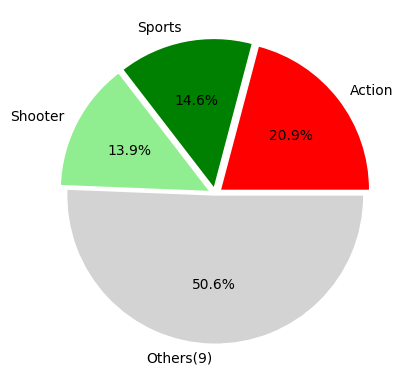

In [154]:
#### 인기가 많은 게임에 대한 분석
## 수요 = 게임의 인기 * 인구
## 게임의 인기 = 수요/인구
## 북아메리카의 인구: 5.95억 유럽 인구: 4.98억 일본 인구: 1.23억 나머지 인구: 중국 인도 한국 대만 사우디 베트남 14.25+ 14.28 + 2.5 = 31억
## 지역별 게임의 인기도 컬럼 생성
ndf = df.copy()
ndf['NA_Pop'] = ndf['NA_Sales']*100/5.95
ndf['EU_Pop'] = ndf['EU_Sales']*100/4.98
ndf['JP_Pop'] = ndf['JP_Sales']*100/1.23
ndf['Other_Pop'] = ndf['Other_Sales']*100/31
ndf['World_Pop'] = ndf['Whole_Sales']*100/(5.95 + 4.98 + 1.23 + 31)
NA_popgame = ndf.query('NA_Pop >= %f' %(np.percentile(ndf['NA_Pop'],95)))
EU_popgame = ndf.query('EU_Pop >= %f' %(np.percentile(ndf['EU_Pop'],95)))
JP_popgame = ndf.query('JP_Pop >= %f' %(np.percentile(ndf['JP_Pop'],95)))
Other_popgame = ndf.query('Other_Pop >= %f' %(np.percentile(ndf['Other_Pop'],95)))
World_popgame = ndf.query('World_Pop >= %f' %(np.percentile(ndf['World_Pop'],95)))

na_p = NA_popgame['Genre'].value_counts(normalize=True)[:3]
na_p = pd.concat([na_p,pd.Series(1-na_p.sum())])
eu_p = EU_popgame['Genre'].value_counts(normalize=True)[:3]
eu_p = pd.concat([eu_p,pd.Series(1-eu_p.sum())])
jp_p = JP_popgame['Genre'].value_counts(normalize=True)[:3]
jp_p = pd.concat([jp_p,pd.Series(1-jp_p.sum())])
ot_p = Other_popgame['Genre'].value_counts(normalize=True)[:3]
ot_p = pd.concat([ot_p,pd.Series(1-ot_p.sum())])
w_p = World_popgame['Genre'].value_counts(normalize=True)[:3]
w_p = pd.concat([w_p,pd.Series(1-w_p.sum())])

na_label = np.append(NA_popgame['Genre'].value_counts(normalize=True)[:3].index.values,'Others(9)')
eu_label = np.append(EU_popgame['Genre'].value_counts(normalize=True)[:3].index.values,'Others(9)')
jp_label = np.append(JP_popgame['Genre'].value_counts(normalize=True)[:3].index.values,'Others(9)')
ot_label = np.append(Other_popgame['Genre'].value_counts(normalize=True)[:3].index.values,'Others(9)')
w_label = np.append(World_popgame['Genre'].value_counts(normalize=True)[:3].index.values,'Others(9)')

plt.pie(na_p,labels = na_label,autopct='%.1f%%',explode=explode,colors=color1)


([<matplotlib.patches.Wedge at 0x1c7d5b49d20>,
 [Text(0.8872816757633395, 0.7315949889485306, 'Action'),
  Text(-0.2929777527219981, 1.1120539718961342, 'Shooter'),
  Text(-1.035837934375996, 0.49953956170424585, 'Sports'),
  Text(-0.01934821876083366, -1.109831359455473, 'Others(9)')],
 [Text(0.5015070341271048, 0.41351021114482156, '21.9%'),
  Text(-0.165596121103738, 0.6285522449847715, '14.3%'),
  Text(-0.5854736150820846, 0.2823484479197911, '13.2%'),
  Text(-0.01063280490460228, -0.6099073236647193, '50.6%')])

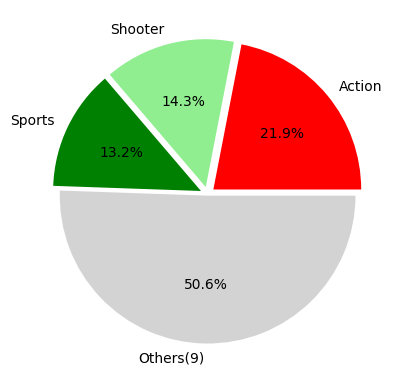

In [155]:
color3 = ['red','lightgreen','green','lightgray']
plt.pie(eu_p,labels = eu_label,autopct='%.1f%%',explode=explode,colors=color3)


([<matplotlib.patches.Wedge at 0x1c7d5b020b0>,
 [Text(0.7820397933084983, 0.8431570207748978, 'Role-Playing'),
  Text(-0.4931018619607045, 1.0389179725709277, 'Action'),
  Text(-1.0389179841128093, 0.49310183764307414, 'Sports'),
  Text(-0.07022342157992055, -1.1077764535598367, 'Others(9)')],
 [Text(0.44202249187002074, 0.47656701174233346, '26.2%'),
  Text(-0.27870974806474597, 0.5872145062357417, '11.7%'),
  Text(-0.5872145127594139, 0.2787097343199984, '10.1%'),
  Text(-0.038591249697073456, -0.6087780510554056, '52.0%')])

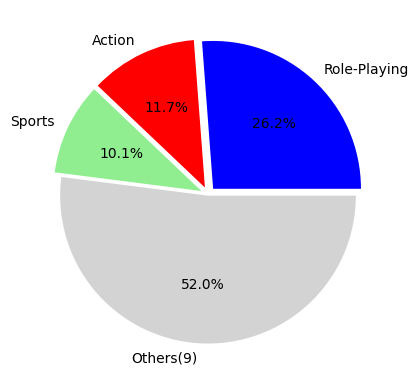

In [156]:

plt.pie(jp_p,labels = jp_label,autopct='%.1f%%',explode=explode,colors=color2)

([<matplotlib.patches.Wedge at 0x1c7d8029450>,
 [Text(0.8630365197233081, 0.7600447129109444, 'Action'),
  Text(-0.3979310120160156, 1.0789582520542258, 'Sports'),
  Text(-1.102621789268305, 0.32668821501664536, 'Shooter'),
  Text(0.0894268608437362, -1.1063918096947551, 'Others(9)')],
 [Text(0.4878032502783915, 0.429590489906186, '23.0%'),
  Text(-0.22491752853079142, 0.6098459685523883, '15.3%'),
  Text(-0.6232210113255635, 0.18464986066158218, '14.3%'),
  Text(0.04914449109430548, -0.6080171206430636, '47.4%')])

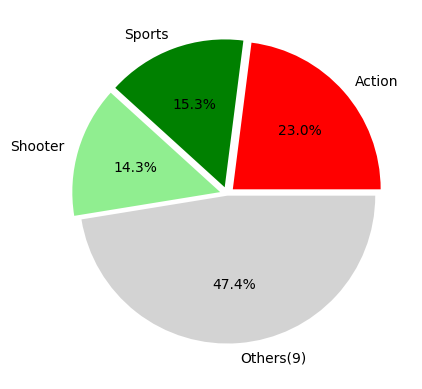

In [157]:
plt.pie(ot_p,labels = ot_label,autopct='%.1f%%',explode=explode,colors=color1)

([<matplotlib.patches.Wedge at 0x1c7d8088760>,
 [Text(0.9162660957864561, 0.6949506757405483, 'Action'),
  Text(-0.16775544665691747, 1.1376986024940603, 'Sports'),
  Text(-0.94821739047705, 0.6506794759302724, 'Shooter'),
  Text(-0.10961843416782296, -1.1045740350427375, 'Others(9)')],
 [Text(0.5178895324010404, 0.3927982080272664, '20.7%'),
  Text(-0.09481829593651857, 0.643047036192295, '13.4%'),
  Text(-0.5359489598348544, 0.3677753559605887, '12.8%'),
  Text(-0.06024076111925406, -0.6070181634018647, '53.1%')])

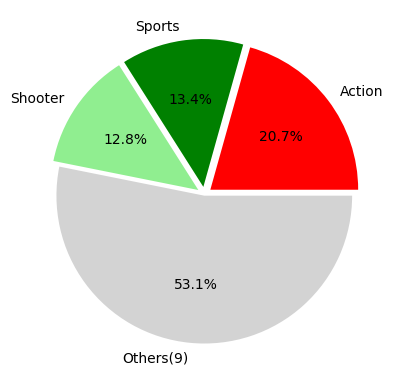

In [158]:
plt.pie(w_p,labels = w_label,autopct='%.1f%%',explode=explode,colors=color1)